In [1]:
import requests
# from minio import Minio
import tempfile
import pyarrow.parquet as pq
import pyarrow as pa
import awkward
from confluent_kafka import Consumer, KafkaException
import uproot_methods
from coffea import hist
import matplotlib.pyplot as plt

In [2]:
n_workers = 17
servicex_endpoint = "http://release-name-servicex-app.servicex:8000/servicex"
response = requests.post(servicex_endpoint+"/transformation", json={
    "did": "mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00",
    # "did": "data17_13TeV:data17_13TeV.periodK.physics_Main.PhysCont.DAOD_STDM7.grp22_v01_p3713",
    # "did": "data18_13TeV:data18_13TeV.periodL.physics_Main.PhysCont.DAOD_SUSY2.grp18_v01_p3704",
    "columns": "Electrons.pt(), Electrons.eta(), Electrons.phi(), Electrons.e(), Muons.pt(), Muons.eta(), Muons.phi(), Muons.e()",
    "image": "sslhep/servicex-transformer:v0.1-prep",
    "result-destination": "kafka",
    "kafka":{
        # "broker": "servicex-kafka-1.slateci.net:19092"
        "broker": "release-name-kafka:9092"
    },
    "chunk-size": 3000,
    "workers": n_workers
})

print(response.json())
request_id = response.json()["request_id"]
status_endpoint = servicex_endpoint+"/transformation/{}/status".format(request_id)

{'request_id': '85cc5d37-59b6-4381-be42-5c4c7b813982'}


In [27]:
status = requests.get(status_endpoint).json()
# print("We have processed {} files there are {} remainng".format(status['files-processed'], status['files-remaining']))

print("Request ID:                 ", status['request-id'])
print("Number of files processed:  ", status['files-processed'])
print("Number of files remaining:  ", status['files-remaining'])
if status['stats']:
    print("Number of events processed: ", status['stats']['total-events'])
    print("Size of files processed:    ", status['stats']['total-bytes'] / 1.0e9, "GB")
    print("Number of batches sent:     ", status['stats']['total-messages'])
    print("Total time:                 ", status['stats']['total-time'] / (n_workers * 60), "min")

Request ID:                  85cc5d37-59b6-4381-be42-5c4c7b813982
Number of files processed:   5
Number of files remaining:   0
Number of events processed:  424800
Size of files processed:     0.055744344 GB
Number of batches sent:      143
Total time:                  0.4088235294117647 min


In [34]:
conf = {'bootstrap.servers': "servicex-kafka-1.slateci.net:19092",
        'group.id': "foo3",
        'default.topic.config': {'auto.offset.reset': 'smallest'}}

c = Consumer(conf)

print(c.list_topics().topics[request_id])
    
c.subscribe([request_id])
timeout = 10.0 # Need a long timeout to allow for partition assignment
running = True
all_mass_hists = None

85cc5d37-59b6-4381-be42-5c4c7b813982


In [35]:
while running:
    msg = c.poll(timeout=timeout)
    if msg is None:
        running = False
        continue
    if msg.error():
        raise KafkaException(msg.error())
    else:
        # Proper message
        buf = msg.value()
        reader = pa.ipc.open_stream(buf)
        batches = [b for b in reader]
        for batch in batches:
            arrays = awkward.fromarrow(batch)
            v_particles = uproot_methods.TLorentzVectorArray.from_ptetaphi(
                arrays['Electrons_pt'], arrays['Electrons_eta'],
                arrays['Electrons_phi'], arrays['Electrons_e']
            )
            # v_particles = uproot_methods.TLorentzVectorArray.from_ptetaphi(
                # arrays['Muons_pt'], arrays['Muons_eta'],
                # arrays['Muons_phi'], arrays['Muons_e']
            # )
            v_particles = v_particles[v_particles.counts >= 2]
            diparticles = v_particles[:, 0] + v_particles[:, 1]
            
            mass_hist = hist.Hist('Counts', hist.Bin('mass', r'$m_{\mu\mu}$ (GeV)', 150, 0.0, 150.0))
            mass_hist.fill(mass=diparticles.mass/1000.0)
            
            if all_mass_hists:
                all_mass_hists = all_mass_hists.add(mass_hist)
            else:
                all_mass_hists = mass_hist
            
            # n_events = len(arrays.tolist())
            # print("Number of events: " + str(n_events))

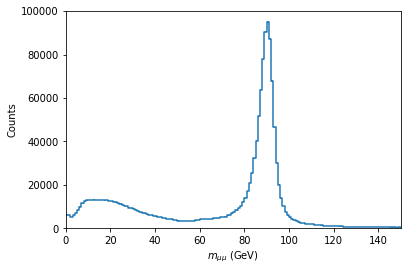

In [36]:
fig, ax, _ = hist.plot1d(all_mass_hists)
plt.show()